# Setup

### Constants

Modify these constants and then run the whole file

In [2]:
JVS_FILE_PATH = './jvs_mock.csv'  # path to the job vacancy survey CSV
OJV_FILE_PATH = './ojv_mock.csv'  # path to the online job vacancy CSV

Both CSV files need to have the following format:

```
date,sic,count
12-01-01,a-agriculture,2
12-01-01,b-mining-quarrying,16
12-01-01,c-manufacturing,882
12-01-01,d-electricity-gas-etc,4
...
```

I.e. 3 columns: "date" (string in format YY-MM-DD), "sic" (Standard industry classification - i.e. industry sector), and "count" (stock number of vacancies at given date in given sector). The order of the rows is not relevant

In [3]:
# the default test date - data up to this point would be used for training/fitting the model, 
# data beyond this point will be used for testing the model
DEF_TEST_START_DATE = '2018-01'

In [4]:
# the default ARIMA and S-ARIMA parameters. 
# The ARIMA model takes the values P (number of time-lags), D (degree of diferencing) and Q (order of moving average)
# in our case we used these defaults. One may need to tweak these based on their scenario though! 
# (see corresponding section below)
DEF_PDQ = (1, 1, 1)
DEF_SPDQ = (12, 1, 1, 1)

### Imports

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats

from ipywidgets import interact, interactive, widgets
from ipywidgets import Layout, Button, Box, HBox, VBox, Label

import statsmodels.api as sm
import itertools

%matplotlib inline

### Load data

In [6]:
ojv = pd.read_csv(OJV_FILE_PATH)
jvs = pd.read_csv(JVS_FILE_PATH)

In [7]:
# convert the date column from string -> date format
ojv['date'] = pd.to_datetime(ojv['date'], format='%y-%m-%d')
jvs['date'] = pd.to_datetime(jvs['date'], format='%y-%m-%d')

In [8]:
# sort data in case they are not sorted
ojv = ojv.sort_values(by=['date', 'sic'])
jvs = jvs.sort_values(by=['date', 'sic'])

In [9]:
# get list of unique SICs (unique industry sectors) that are common in both datasets
sics = list(sorted(set(jvs['sic'].unique()) & set(ojv['sic'].unique())))
sics

['b-mining-quarrying',
 'c-manufacturing',
 'd-electricity-gas-etc',
 'e-water-sewerage-waste-etc',
 'f-construction',
 'g-motor-trades-wholesale-retail',
 'h-transport-storage',
 'i-accomodation-food-services',
 'j-information-comms',
 'k-financial-insurance',
 'l-real-estate',
 'm-professional-scientific-technical',
 'n-admin-support-services',
 'o-public-admin',
 'p-education',
 'q-human-health',
 'r-arts-entertainment-recreation',
 's-other-services']

In what follows, unspecified SIC (i.e. SIC == None) means the selecting the totals (sum of all industries)

# Analysis

We use some custom defined functions below - each has description and is run immediatelly to produce an example!

### Data processing methods & initial exploration

In [9]:
def get_sr(df, sic=None, day_resample=False, standardize=False):
    """
    We will use this method to pick time-series for individual SICs or for the total.
    
    :param day_resample: if True, ensures there's one entry per day (i.e. if there isn't, a zero value will be inserted)
    :standardize: if True, will standardize the final series to 0 mean and unit variance
    """
    if sic is None:
        df = df.groupby('date')['count'].sum().reset_index()
    else:
        df = df[df['sic'] == sic]
        
    sr = df.set_index('date')['count']
    
    if day_resample:
        sr = sr.resample('1D').mean().fillna(0)
        
    if standardize:
        sr = (sr - sr.mean()) / sr.std()
    
    return sr
    
sr = get_sr(ojv, sics[0], standardize=True)
sr.head(5)

date
2012-01-06    0.122374
2012-02-03    0.641845
2012-03-02    0.917229
2012-04-06    0.935530
2012-05-04    0.357467
Name: count, dtype: float64

In [10]:
def get_df(sic=None, standardize=False):
    """
    We will use this method to get a dataframe with OJV and JVS time-series values side by side for the specified SIC code
    """
    sr_ojv = get_sr(ojv, sic=sic, standardize=standardize)
    sr_jvs = get_sr(jvs, sic=sic, standardize=standardize)
    
    df = pd.concat([sr_ojv, sr_jvs], axis=1)
    df.columns = ['ojv', 'jvs']
    
    return df

df = get_df().dropna()
df.head()

,ojv,jvs
date,,
2012-01-06,413304.343601,428514.624073
2012-02-03,441174.833433,424342.442611
2012-03-02,479385.052454,470300.766131
2012-04-06,466701.957433,471429.092006
2012-05-04,475003.880455,465326.443466


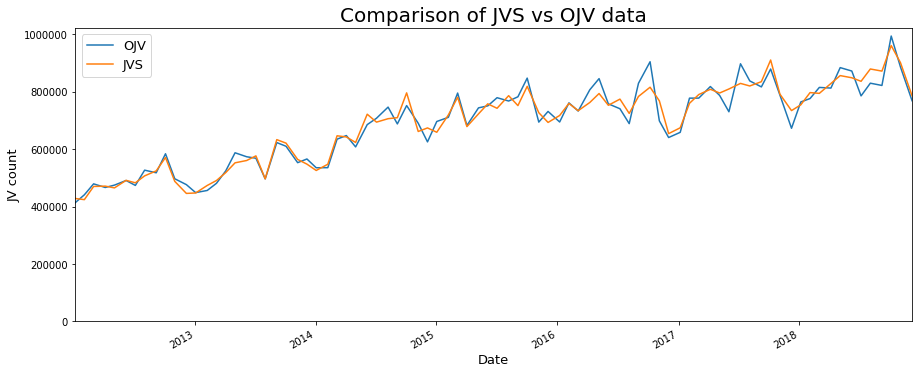

In [11]:
def plot_time_series(sic=None, standardize=False):
    """
    A method plotting the two time-series (JVS, OJV) for specified SIC code/totals.
    """
    sic = sic
    plt.figure(figsize=(15, 6))

    df = get_df(sic, standardize)
    
    df['ojv'].dropna().plot(ax=plt.gca(), label='OJV')
    df['jvs'].dropna().plot(ax=plt.gca(), label='JVS')
    
    if not standardize:
        plt.ylim(0, plt.ylim()[1])
    
    plt.xlabel('Date', fontsize=13)
    plt.ylabel('JV count', fontsize=13)
    plt.legend(fontsize=13)
    plt.title('Comparison of JVS vs OJV data' + ('' if sic is None else ' (SIC = {})'.format(sic)), fontsize=20)
    
plot_time_series()

In [12]:
# here we just use the previous function to make a mini interactive dashboard where one can select
# which SIC code to explore/whether to standardize the data

style = {'description_width': 'initial'}
    
basic_widgets = dict(
    sic=widgets.Dropdown(options=sics + [None], value=None, style=style, description='SIC'),
    standardize=widgets.Checkbox(value=False, description='Standardize', style=style),
)

inter = interactive(plot_time_series, **basic_widgets)
rows = [
    Box(children=[basic_widgets['sic'], basic_widgets['standardize']]),
    inter.children[-1]
]
VBox(rows)

### Time series modelling

In [13]:
def get_test_start_index(df, test_start_date):
    """
    Returns the row number in the dataframe from which the data should serve for testing 
    (conversely, data up to the returned row number serve for training/fitting the model)
    """
    return len([d for d in df.index if str(d) < test_start_date])

get_test_start_index(df, DEF_TEST_START_DATE)

72

In [14]:
def get_test_start_date(df, test_start_index):
    """
    Complementary function to the above
    """
    
    return df.index[test_start_index].strftime('%Y-%m')

get_test_start_date(df, get_test_start_index(df, DEF_TEST_START_DATE))

'2018-01'

In [15]:
def fit_model(df, pdq=DEF_PDQ, spdq=DEF_SPDQ, test_start_date=DEF_TEST_START_DATE, ojv_as_exo=True):
    """
    Fits the S-ARIMA model on the data given by dataframe, using rows with date 
    up to specified test start date.
    
    :param ojv_as_exo: OJV data will be used as exogenous regressor
    """
    test_start_index = get_test_start_index(df, test_start_date)
    df = df.iloc[:test_start_index]
    
    model = sm.tsa.statespace.SARIMAX(
        endog=df['jvs'].values,
        exog=df['ojv'].values if ojv_as_exo else None,
        order=pdq,
        seasonal_order=spdq,
        time_varying_regression=ojv_as_exo,
        mle_regression=not ojv_as_exo,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    mle_res = model.fit(maxiter=1000)
    
    return mle_res

m_exo = fit_model(df, ojv_as_exo=True)
m_jvs = fit_model(df, ojv_as_exo=False)
m_exo.summary()  # check fitted model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(12, 1, 1, 1)   Log Likelihood                -659.700
Date:                            Mon, 13 May 2019   AIC                           1353.401
Time:                                    14:46:30   BIC                           1387.831
Sample:                                         0   HQIC                          1366.749
                                             - 72                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2784      2.351      0.118      0.906      -4.329       4.885
ma.L1          0.3700      0.596      0.621      0.535      -0.798       1.538
ar.S.L1       -2.1865      1.046     -2.090      0.037      -4.237      -0.136
ar.S.L2       -2.7641      2.678     -1.032      0.302      -8.014       2.485
ar.S.L3       -3.1701      3.715     -0.853      0.393     -10.451       4.110
ar.S.L4       -3.6101      4.149     -0.870      0.384     -11.743       4.523
ar.S.L5       -3.7403      4.227     -0.885      0.376     -12.025       4.544
ar.S.L6       -3.4642      4.091     -0.847      0.397     -11.483       4.555
ar.S.L7       -3.2434      4.017     -0.808      0.419     -11.116       4.629
ar.S.L8       -2.6868      3.774     -0.712      0.476     -10.083       4.710
ar.S.L9       -1.9638      3.282     -0.598      0.550      -8.397       4.469
ar.S.L10      -1.6286      2.652     -0.614      0.539      -6.826       3.569
ar.S.L11      -1.3217      1.656     -0.798      0.425      -4.567       1.924
ar.S.L12      -0.6722      0.605     -1.111      0.267      -1.859       0.514
ma.S.L1       -0.8260      0.883     -0.936      0.349      -2.556       0.904
var.x1      1.336e-10      0.001   2.28e-07      1.000      -0.001       0.001
sigma2      1.348e+09   1.36e-08   9.89e+16      0.000    1.35e+09    1.35e+09
===================================================================================
Ljung-Box (Q):                       53.79   Jarque-Bera (JB):                 3.86
Prob(Q):                              0.07   Prob(JB):                         0.15
Heteroskedasticity (H):               1.68   Skew:                            -0.64
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+35. Standard errors may be unstable.
"""

In [16]:
# If you want to tweak the values of P/D/Q for your case, 
# try fitting the S-ARIMA model for various combinations of 
# S/P/D/Q and check the AIC/BIC of the fitted models

p = d = q = list(range(0, 2))

pdqs = list(itertools.product(p, d, q))
spdqs = [x + (12,) for x in list(itertools.product(p, d, q))]

pdqs, spdqs

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (1, 0, 0),
  (1, 0, 1),
  (1, 1, 0),
  (1, 1, 1)],
 [(0, 0, 0, 12),
  (0, 0, 1, 12),
  (0, 1, 0, 12),
  (0, 1, 1, 12),
  (1, 0, 0, 12),
  (1, 0, 1, 12),
  (1, 1, 0, 12),
  (1, 1, 1, 12)])

In [17]:
def get_predictions(df, model, test_start_date=DEF_TEST_START_DATE, with_exo=True):
    """
    Uses the fitted model to make predictions on the data starting from 
    given test date. Returns both means and confidence intervals around
    the means
    """
    test_start_index = get_test_start_index(df, test_start_date)
    
    preds = model.get_prediction(
        start=test_start_index, 
        end=len(df) - 1, 
        dynamic=True, 
        full_results=True, 
        exog=df['ojv'].iloc[test_start_index:].values.reshape(-1, 1) if with_exo else None
    )
    
    preds = {
        'means': preds.predicted_mean,
        'ci': preds.conf_int()
    }
    
    return preds

preds_exo = get_predictions(df, m_exo, with_exo=True)
preds_jvs = get_predictions(df, m_jvs, with_exo=False)
preds_exo

{'means': array([762651.52863152, 830578.83585583, 810265.74405485, 832495.30374408,
        842879.62359213, 863045.41259453, 808767.67003938, 842093.31939786,
        835001.58194668, 942934.55757569, 875532.36484302, 793342.52694186]),
 'ci': array([[ 687231.34722135,  838071.7100417 ],
        [ 741941.63822413,  919216.03348753],
        [ 704013.67634057,  916517.81176912],
        [ 707868.67308073,  957121.93440743],
        [ 696851.29569873,  988907.95148553],
        [ 696398.46845731, 1029692.35673174],
        [ 624377.42521398,  993157.91486478],
        [ 641248.69231463, 1042937.9464811 ],
        [ 616392.91884433, 1053610.24504904],
        [ 709229.92448487, 1176639.19066652],
        [ 627887.79213451, 1123176.93755153],
        [ 529519.48556923, 1057165.56831449]])}

In [18]:
def calculate_errs(df, preds_exo, preds_jvs):
    """
    Returns a dataframe with errors against the actual value on the test data
    """
    assert len(preds_exo['means']) == len(preds_jvs['means']), 'different lengths of predictions'
    
    test_start_index = len(df) - len(preds_exo['means'])

    pred_index = df.index[test_start_index:]
    
    vals_true = df['jvs'].iloc[test_start_index:]
    vals_pred_exo = preds_exo['means']
    vals_pred_jvs = preds_jvs['means']
    
    errs = pd.DataFrame({
        'jvs': vals_pred_jvs - vals_true,
        'exo': vals_pred_exo - vals_true
    })
    
    return errs

err_df = calculate_errs(df, preds_exo, preds_jvs)
err_df

,jvs,exo
date,,
2018-01-05,34252.819679,7941.060546
2018-02-02,56366.511670,33305.248641
2018-03-02,87631.498685,15660.796355
2018-04-06,11338.093048,3432.012985
2018-05-04,-30480.451333,-13626.943071
2018-06-08,18889.135813,14107.372567
2018-07-06,59585.541052,-27878.001296
2018-08-03,-11616.547818,-37453.749837
2018-09-07,35055.158434,-37153.853020


In [1]:
def plot_predictions(df, preds_exo=None, preds_jvs=None, ax=None, since_year=None, ylim_focus=False):
    """
    Makes a plot out of the predictions, including correlation of the two
    series on training period and the reduction in RMSE error when using 
    the OJV data as exog. regressor (compared to not using it at all)
    
    :param since_year: the data from previous years will not be included in the plot
    :param ylim_focus: if False, y axis will start at 0 (otherwise it will fit the data)
    """
    if ax is None:
        plt.figure(figsize=(12, 5))
        ax = plt.gca()

    alpha = .7
    lw = 5
    
    # plot the two time series
    sr_jvs = df['jvs']
    sr_ojv = df['ojv']
    if since_year is not None:
        sr_jvs = sr_jvs[sr_jvs.index > str(since_year)]
        sr_ojv = sr_ojv[sr_ojv.index > str(since_year)]

    sr_jvs.plot(ax=ax, label='True JVS', color='Blue', alpha=alpha, linewidth=lw, ls='-')
    sr_ojv.plot(ax=ax, label='True OJV', color='DarkOrange', alpha=alpha, linewidth=lw, ls='-')
    
    # plot the predictions and their confidence intervals
    for preds, pred_color, label in [(preds_exo, 'Red', 'Nowcast - OJV as exo.'), (preds_jvs, 'Green', 'Nowcast - JVS only')]:
        if preds is None:
            continue
            
        test_start_index = len(df) - len(preds['means'])

        pred_index = df.index[test_start_index:]
        pred_vals = preds['means']
        pred_cis = preds['ci']

        pred_sr = pd.Series(data=pred_vals, index=pred_index)

        pred_sr.plot(ax=ax, label=label, color=pred_color, alpha=alpha, linewidth=lw, ls=':')

        ax.fill_between(pred_index, pred_cis[:, 0], pred_cis[:, 1], color=pred_color, alpha=.2)
        
    # tweak the plot
    plt.sca(ax)
    plt.legend(loc='best')
    plt.xlabel('Date', fontsize=13)
    plt.ylabel('Count', fontsize=13)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    if not ylim_focus:
        plt.ylim(0, plt.ylim()[1])

    # create title, including correlation and RMSE reduction 
    # (when using OJV as exo. regressor, compared to not using it)
    title = 'S-ARIMA-X forecasts.\n'
    corr = stats.pearsonr(df.iloc[:test_start_index]['ojv'], df.iloc[:test_start_index]['jvs'])
    title += 'Correlation on train data: {:.2f} '.format(corr[0], corr[1])
    if corr[1] < 0.001:
        title += '(p-val < 0.001). '
    else:
        title += '(p-val {:.4f}). '.format(corr[1])
    
    if preds_exo is not None and preds_jvs is not None:
        err_df = calculate_errs(df, preds_exo, preds_jvs)
        rmses = err_df.pow(2).mean().pow(0.5)
        title += '\nRMSE reduction: {:.2f}% when using OJV as exo. reg.'.format(100 - 100*rmses['exo']/rmses['jvs'])
    
    plt.grid(color='grey', alpha=0.3)
    plt.title(title, fontsize=18, fontweight=400)
    
plot_predictions(df, preds_exo, preds_jvs, since_year=2016)

NameError: name 'df' is not defined

### Exploration dashboard

In [20]:
def get_preds(sic=None, test_start_date=DEF_TEST_START_DATE, gradual=None):
    """
    This method combines some previous methods and returns predictions
    for data of given SIC code
    
    :param gradual: if not None, instead of fitting the model on training data once
    and forecasting the whole of testing period, we repeatedly fit the model
    and forecast just given number of months ahead. Note: this could make
    both models better (the one with and without exog. regressor)
    """
    df = get_df(sic, False)
    df = df.dropna()
    
    test_start_index = get_test_start_index(df, test_start_date)
    
    if gradual is None:
        m_jvs = fit_model(df, DEF_PDQ, DEF_SPDQ, test_start_date, ojv_as_exo=False)
        preds_jvs = get_predictions(df, m_jvs, test_start_date, with_exo=False)

        m_exo = fit_model(df, DEF_PDQ, DEF_SPDQ, test_start_date, ojv_as_exo=True)
        preds_exo = get_predictions(df, m_exo, test_start_date, with_exo=True)
    else:
        preds_jvs = {'means': [], 'ci': []}
        preds_exo = {'means': [], 'ci': []}
        
        for ti in range(test_start_index, len(df)):
            tsd = get_test_start_date(df, ti)
            m_jvs = fit_model(df, DEF_PDQ, DEF_SPDQ, tsd, ojv_as_exo=False)
            preds_jvs_part = get_predictions(df, m_jvs, tsd, False)

            m_exo = fit_model(df, DEF_PDQ, DEF_SPDQ, tsd, ojv_as_exo=True)
            preds_exo_part = get_predictions(df, m_exo, tsd, True)
            
            preds_jvs['means'].extend(preds_jvs_part['means'][gradual - 1:gradual])
            preds_exo['means'].extend(preds_exo_part['means'][gradual - 1:gradual])
            
            preds_jvs['ci'].extend(preds_jvs_part['ci'][gradual - 1:gradual])
            preds_exo['ci'].extend(preds_exo_part['ci'][gradual - 1:gradual])
        
        preds_jvs['means'] = np.array(preds_jvs['means'])
        preds_exo['means'] = np.array(preds_exo['means'])
        
        preds_jvs['ci'] = np.array(preds_jvs['ci'])
        preds_exo['ci'] = np.array(preds_exo['ci'])
        
    return preds_jvs, preds_exo

get_preds()

({'means': array([788963.28776383, 853640.09888462, 882236.4463843 , 840401.38380637,
         826026.11532992, 867827.17584052, 896231.21238817, 867930.52141725,
         907210.59340034, 924450.70202835, 854284.74147181, 829831.84258371]),
  'ci': array([[ 587314.60591221,  990611.96961544],
         [ 647947.43487277, 1059332.76289646],
         [ 669822.49334241, 1094650.39942619],
         [ 618595.06781251, 1062207.69980023],
         [ 589714.94579442, 1062337.28486543],
         [ 602659.75897161, 1132994.59270943],
         [ 622008.67990713, 1170453.7448692 ],
         [ 582426.72213764, 1153434.32069685],
         [ 608592.74541166, 1205828.44138902],
         [ 605353.65256642, 1243547.75149027],
         [ 529862.34560935, 1178707.13733427],
         [ 472246.57266342, 1187417.11250401]])},
 {'means': array([762651.52863152, 830578.83585583, 810265.74405485, 832495.30374408,
         842879.62359213, 863045.41259453, 808767.67003938, 842093.31939786,
         835001.581946

{'gradual': None, 'test_start_date': '2018-02', 'sic': None}


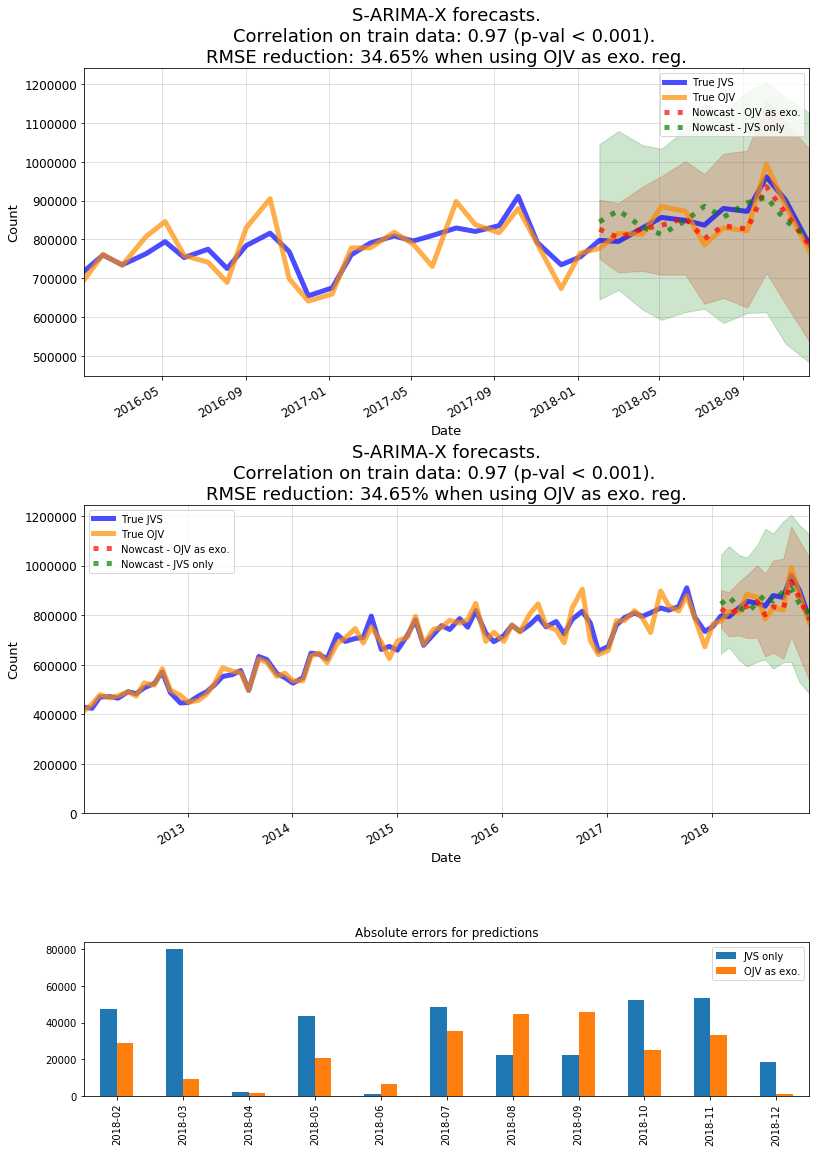

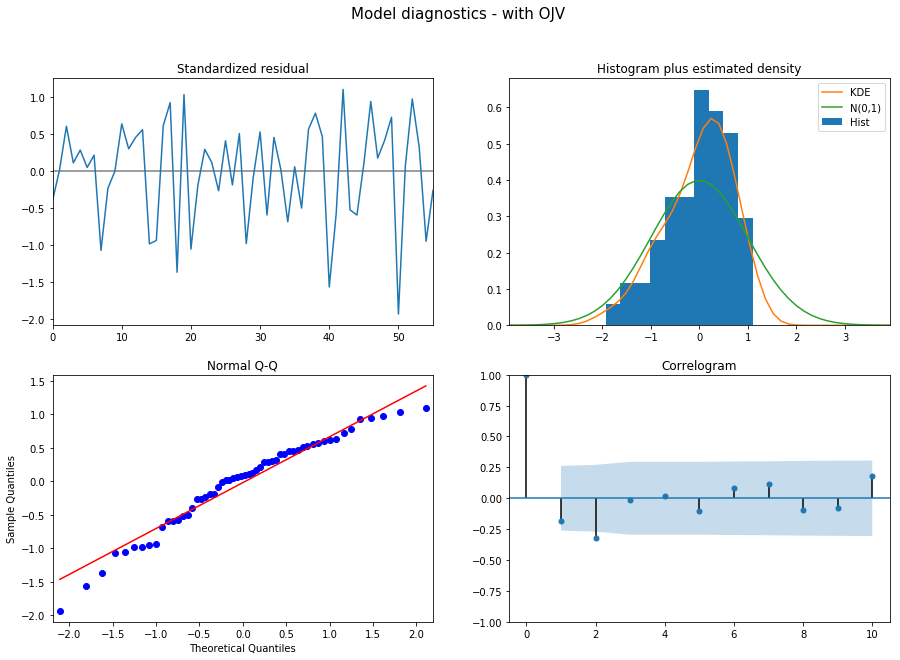

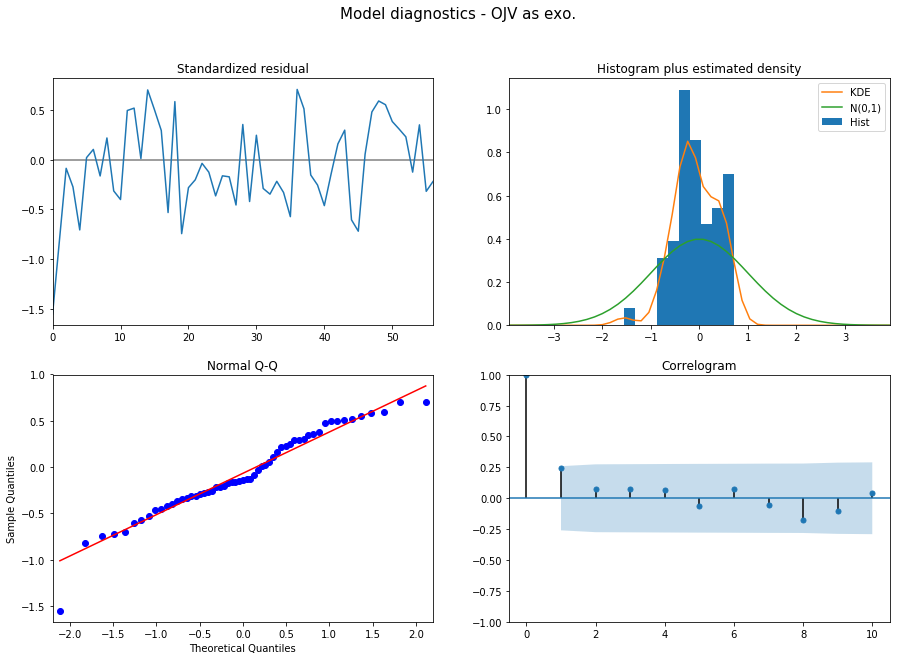

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(12, 1, 1, 1)   Log Likelihood                -659.700
Date:                            Mon, 13 May 2019   AIC                           1353.401
Time:                                    14:46:46   BIC                           1387.831
Sample:                                         0   HQIC                          1366.749
                                             - 72                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2784      2.351      0.118      0.906      -4.329       4.885
ma.L1          0.3700      0.596      0.621      0.535      -0.798       1.538
ar.S.L1       -2.1865      1.046     -2.090      0.037      -4.237      -0.136
ar.S.L2       -2.7641      2.678     -1.032      0.302      -8.014       2.485
ar.S.L3       -3.1701      3.715     -0.853      0.393     -10.451       4.110
ar.S.L4       -3.6101      4.149     -0.870      0.384     -11.743       4.523
ar.S.L5       -3.7403      4.227     -0.885      0.376     -12.025       4.544
ar.S.L6       -3.4642      4.091     -0.847      0.397     -11.483       4.555
ar.S.L7       -3.2434      4.017     -0.808      0.419     -11.116       4.629
ar.S.L8       -2.6868      3.774     -0.712      0.476     -10.083       4.710
ar.S.L9       -1.9638      3.282     -0.598      0.550      -8.397       4.469
ar.S.L10      -1.6286      2.652     -0.614      0.539      -6.826       3.569
ar.S.L11      -1.3217      1.656     -0.798      0.425      -4.567       1.924
ar.S.L12      -0.6722      0.605     -1.111      0.267      -1.859       0.514
ma.S.L1       -0.8260      0.883     -0.936      0.349      -2.556       0.904
var.x1      1.336e-10      0.001   2.28e-07      1.000      -0.001       0.001
sigma2      1.348e+09   1.36e-08   9.89e+16      0.000    1.35e+09    1.35e+09
===================================================================================
Ljung-Box (Q):                       53.79   Jarque-Bera (JB):                 3.86
Prob(Q):                              0.07   Prob(JB):                         0.15
Heteroskedasticity (H):               1.68   Skew:                            -0.64
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+35. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(12, 1, 1, 1)   Log Likelihood                -716.059
Date:                            Mon, 13 May 2019   AIC                           1464.119
Time:                                    14:46:46   BIC                           1496.808
Sample:                                         0   HQIC                          1476.823
                                             - 72                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1953      2.370     -0.082      0.934      -4.841       4.450
ma.L1          0.9074      0.176      5.162      0.000       0.563       1.252
ar.S.L1       -1.9163      2.054     -0.933      0.351      -5.942       2.110
ar.S.L2       -2.0240      3.062     -0.661      0.509      -8.025       3.977
ar.S.L3       -2.1097      3.185     -0.662      0.508      -8.351       4.132
ar.S.L4       -2.0131      3.507     -0.574      0.566      -8.887       4.861
ar.S.L5       -1.6566      3.254     -0.509      0.611      -8.034       4.721
ar.S.L6       -1.4367      2.834     -0.507      0.612      -6.992       4.118
ar.S.L7       -1.4418      2.782     -0.518      0.604      -6.895       4.011
ar.S.L8       -1.4139      2.505     -0.564      0.573      -6.324       3.496
ar.S.L9       -1.3089      2.218     -0.590      0.555      -5.657       3.039
ar.S.L10      -1.4359      2.182     -0.658      0.511      -5.713       2.841
ar.S.L11      -1.2754      2.231     -0.572      0.567      -5.647       3.096
ar.S.L12      -0.4779      1.293     -0.370      0.712      -3.013       2.057
ma.S.L1       -1.6819      0.124    -13.602      0.000      -1.924      -1.440
sigma2      3.742e+09   1.92e-09   1.95e+18      0.000    3.74e+09    3.74e+09
===================================================================================
Ljung-Box (Q):                       28.38   Jarque-Bera (JB):                 2.23
Prob(Q):                              0.92   Prob(JB):                         0.33
Heteroskedasticity (H):               0.47   Skew:                            -0.42
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+35. Standard errors may be unstable.
"""

,jvs,exo
date,,
2018-02-02,47713.755673,29032.266986
2018-03-02,79978.120847,9581.649166
2018-04-06,2271.927322,-1912.193575
2018-05-04,-43559.749357,-20722.248757
2018-06-08,-1305.677809,6535.886064
2018-07-06,48590.704328,-35272.572966
2018-08-03,-22347.870312,-44619.669835
2018-09-07,22418.003804,-45599.725863
2018-10-05,-52324.250384,-25196.731360


In [21]:
from IPython.display import display, HTML
import matplotlib.dates as mdates

def dashboard_plots(sic=None, test_start_date=DEF_TEST_START_DATE, gradual=None):
    """
    This does it all in one go - fitting models, predicting, plotting the results as 
    well as complex diagnostics of the results. 
    """
    
    if gradual is None or gradual <= 0:
        gradual = None
        
    print(locals())
    
    df = get_df(sic, False).dropna()
        
    preds_jvs, preds_exo = get_preds(sic, test_start_date, gradual)
        
    f, axes = plt.subplots(3, 1, figsize=(13, 21), gridspec_kw={'height_ratios':[2,2,1]})
    plt.subplots_adjust(hspace=0.5)
    
    plot_predictions(df, preds_exo, preds_jvs, ax=axes[0], since_year=2016, ylim_focus=True)
    
    plot_predictions(df, preds_exo, preds_jvs, ax=axes[1], since_year=None, ylim_focus=False)
    
    ax = axes[2]
    err_df = abs(calculate_errs(df, preds_exo, preds_jvs))
    err_df.columns = ['JVS only', 'OJV as exo.']
    err_df.index = [pd.datetime.strftime(d, format='%Y-%m') for d in err_df.index]
    err_df.plot.bar(ax=ax)
    ax.set_title('Absolute errors for predictions')   
    
    m_exo.plot_diagnostics(figsize=(15, 10))
    plt.suptitle('Model diagnostics - with OJV', fontsize=15)
    
    m_jvs.plot_diagnostics(figsize=(15, 10))
    plt.suptitle('Model diagnostics - OJV as exo.', fontsize=15)
    
    plt.show()
    
    display(HTML('<h1> Model summary - OJV as exo. </h1>'))
    display(m_exo.summary())
    display(HTML('<h1> Model summary - only JVS </h1>'))
    display(m_jvs.summary())
    display(HTML('<h1> Errors against true JVS </h1>'))
    display(calculate_errs(df, preds_exo, preds_jvs))
    
dashboard_plots(sic=None, test_start_date='2018-02', gradual=None)

In [22]:
dashboard_widgets = basic_widgets.copy()

dashboard_widgets.update({
    'test_start_date': widgets.Dropdown(
        options=[d.strftime('%Y-%m') for d in df.index], 
        value=DEF_TEST_START_DATE, 
        style=style, 
        description='Test start date'
    ),
    'gradual': widgets.IntSlider(min=0, max=5, value=0, description='Gradual (months)', style=style, continuous_update=False),
})

inter = interactive(dashboard_plots, **dashboard_widgets)
rows = [
    Box(children=[dashboard_widgets['sic'], dashboard_widgets['test_start_date'], dashboard_widgets['gradual']]),
    Box(children=[inter.children[-1]])
]
VBox(rows)

### Further analysis

In [23]:
def comparison_plots(test_start_date=DEF_TEST_START_DATE):  
    """
    This function will run the model on each SIC code, trying both the "one-off" and 
    "gradual" modelling. It outputs the correlations on training data, RMSE reductions
    and errors itself.
    
    Note: this takes long time (minutes/hour)
    """
    
    corrs = []
    rmse_reds = []
    errs = []
    
    sic_list = sics + [None]
    
    for sic in sic_list:
        print(sic)
        df = get_df(sic, False).dropna()
        test_start_index = get_test_start_index(df, test_start_date)
        
        rmse_reds_row = []
        errs_row = []
        for gradual in [2, None]:
            preds_jvs, preds_exo = get_preds(sic, test_start_date, gradual)
            
            err_df = abs(calculate_errs(df, preds_exo, preds_jvs))
            rmses = err_df.pow(2).mean().pow(0.5)
            rmse_red = 100 - 100*rmses['exo']/rmses['jvs']
            
            rmse_reds_row.append(rmse_red)
            errs_row.append(err_df)
            
        corr = stats.pearsonr(df.iloc[:test_start_index]['ojv'], df.iloc[:test_start_index]['jvs'])
        corrs.append(corr)
        
        rmse_reds.append(rmse_reds_row)
        errs.append(errs_row)
        
    rmse_reds = pd.DataFrame(rmse_reds, columns=['gradual', 'one-off'], index=sic_list)
    corrs = pd.DataFrame(corrs, columns=['corr', 'p-val'], index=sic_list)
    
    return corrs, rmse_reds, errs

corrs, rmse_reds, errs = comparison_plots()

b-mining-quarrying


E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


c-manufacturing
d-electricity-gas-etc
e-water-sewerage-waste-etc


E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


f-construction


E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


g-motor-trades-wholesale-retail
h-transport-storage
i-accomodation-food-services
j-information-comms
k-financial-insurance


E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


l-real-estate


E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


m-professional-scientific-technical
n-admin-support-services
o-public-admin
p-education
q-human-health
r-arts-entertainment-recreation


E:\Python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


s-other-services
None


In [24]:
def add_bar_values(ax=None, x_offset=0.1, y_factor=1.1, prec=1, fmt=None, rot=70):
    """
    Just a helper function to add the text with the size of the bar above each bar
    in a bar chart
    """
    if ax is None:
        ax = plt.gca()

    plt.sca(ax)

    for p in ax.patches:
        format = '{0:.' + str(prec) + 'f}'
        if fmt is not None:
            format = fmt
        plt.gca().text(p.get_x() + x_offset, y_factor*p.get_height(), format.format(p.get_height()), rotation=rot)

Text(0.5, 1.0, 'Correlations of OJV with JVS (p-value < 0.01 for green bars)')

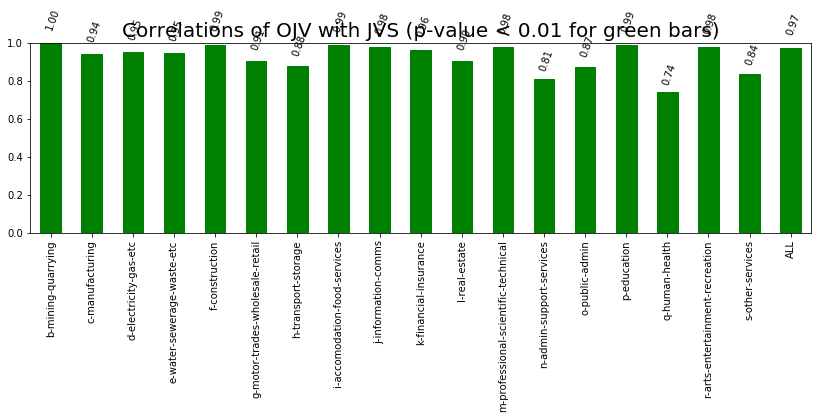

In [25]:
# here we plot the correlations between JVS and OJV on the training data for each industry

plt.figure(figsize=(14, 3.5))

corrs = corrs.rename({None: 'ALL'})

bars = corrs['corr'].plot.bar(color='red')
for bar, pval in zip(bars.patches, corrs['p-val'].values):
    if pval < 0.01:
        bar.set_color('green')
        
add_bar_values(plt.gca(), prec=2, y_factor=1.15)
plt.ylim(0, 1)
        
plt.title('Correlations of OJV with JVS (p-value < 0.01 for green bars)', fontsize=20)

In [26]:
corrs

,corr,p-val
b-mining-quarrying,0.996275,2.984677e-76
c-manufacturing,0.939319,3.011698e-34
d-electricity-gas-etc,0.951879,1.112535e-37
e-water-sewerage-waste-etc,0.946580,3.936633e-36
f-construction,0.989555,1.258901e-60
g-motor-trades-wholesale-retail,0.905634,8.700866e-28
h-transport-storage,0.876206,6.961232e-24
i-accomodation-food-services,0.985821,5.243731e-56
j-information-comms,0.975023,1.767721e-47
k-financial-insurance,0.961712,4.403029e-41


Text(0.5, 1.0, 'RMSE reductions per industry - gradual vs. one-off nowcasting')

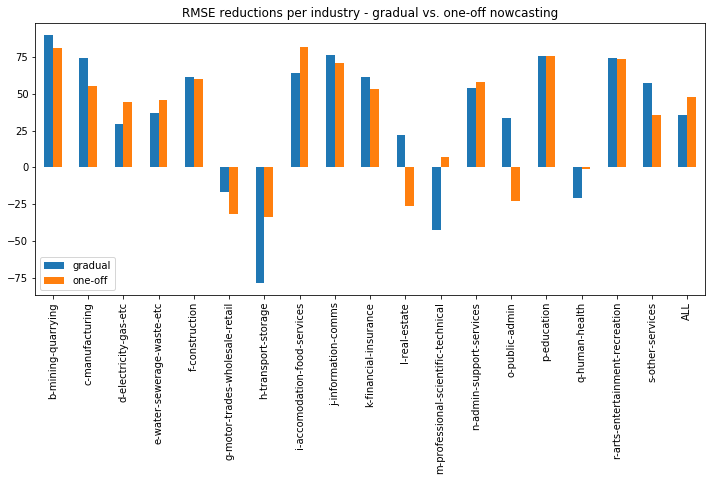

In [27]:
# Here we plot the reductions in RMSE for each industry

rmse_reds = rmse_reds.rename({None: 'ALL'})

rmse_reds.plot.bar(figsize=(12, 5))
plt.title('RMSE reductions per industry - gradual vs. one-off nowcasting')

Text(0.5, 1.0, 'Amount of correlation (BG - JVS) vs. RMSE reduction when using BG data\n (Size of dot indicates correlation significance)')

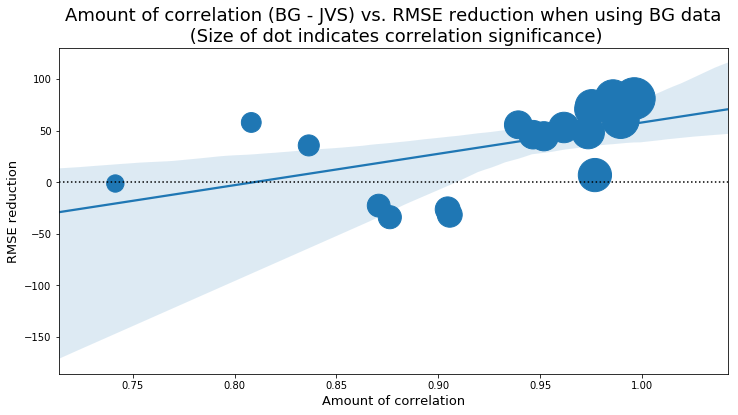

In [28]:
# finally we explore if there is a positive relationship between the amount of
# correlation between OJV and JVS, and the amoung of RMSE that can be reduced
# when adding OJV as exogenous regressor in the model

cor_rmse = pd.concat([corrs, rmse_reds], axis=1)
cor_rmse['1 - (p-val)'] = -np.log(cor_rmse['p-val'])*10
cor_rmse.plot.scatter(x='corr', y='one-off', figsize=(12, 6), s=cor_rmse['1 - (p-val)'])
import seaborn as sns
sns.regplot(x='corr', y='one-off', data=cor_rmse)

plt.gca().axhline(y=0, color='black', ls=':')
plt.xlabel('Amount of correlation', fontsize=13)
plt.ylabel('RMSE reduction', fontsize=13)
plt.title('Amount of correlation (BG - JVS) vs. RMSE reduction when using BG data' + 
          '\n (Size of dot indicates correlation significance)', fontsize=18)